HUC12 vs Reach COMIDs Analysis
===

**Authors:** Xavier Nogueira, Anthony Aufenkampe

**Goal:** For every HUC12 basin, we want to know the COMID of reaches flowing into it, and reaches flowing out of it.

**Notes:**

- As of 2023-Oct-22, this notebooks depends on outputs from `geography/HUC hierarchy.ipynb`

* There is a new river network for NHDPlusV2 that contains attributes (inclduing `tocomid`).
    * Available as a geo-parquet: https://www.sciencebase.gov/catalog/item/63cb311ed34e06fef14f40a3
    * Some COMIDs are designated "Mainstems": https://www.sciencebase.gov/catalog/item/63cb38b2d34e06fef14f40ad. IN the link we can find cross-walks for CONUS mainstems for NHDplus v1 and v2.
* NLDI (Network-Linked Data Index) - Has upstream/downstream links for a *subset* of NHDPlus data. Includes outlets of HUC12 watersheds.
    * https://waterdata.usgs.gov/blog/nldi-intro/
    * Has a web API (docs: https://labs.waterdata.usgs.gov/api/nldi/swagger-ui/index.html).
    * "Feature sources" include sources for geospatial features that are linked up to the NLDI.
    * Navigation types include: upstream mainstem, downstream tributaries, downstream mainstem, downstream diversions. This allows you to search (using some distance threshold in KM) for data features from other sources.
    * Example: `https://labs.waterdata.usgs.gov/api/nldi/linked-data/comid/1748535/navigation/DM/flowlines?distance=50` will check 50km downstream from a given COMID for all **mainstem** flowlines. **We can use this to ID mainstem COMIDs which will be considered baseline!**
    * Could we use coordinates to connect the network? It seems that the first coordinate from the response is upstream, and therefore if the first coordinate is found as the last coordinate for another COMID then we can make the link!
    * Starting with a low down mainstem COMID we can make an "UT" request and link it using coordinates and algos?
* A core issue is that Model My Watershed and WikiSRAT use outdated hydrography that may not match the upated APIs/datasets!
    * They use this data: https://nhdplus.com/NHDPlus/NHDPlusV2_home.php
    * VAAs = Value Added Attributes. This may be where we can pull the old version COMID linkages.
    * There is a cross walk we can download! See the links @ https://www.epa.gov/waterdata/nhdplus-national-data
* This R package seems to do what we need (linking the network): https://github.com/lawinslow/hydrolinks
    * Could we have a Python traversal version?
    * Basically does what we describe above. Uses lat/lons to link lakes, streams, and rivers. Still need to specify traversal distance to avoid endless processing (i.e., Mississippi watershed).
    * **We should get someone with R skills to explain**

**As a first step we can assume the HUC12 connections are legit, ID mainstems, and traverse the network**

**Ideas:**
* [`networkx`](https://networkx.org/) can be used to represent the network of COMIDs. This is what is under the hood of [`pynhd.network_tools`](https://hyriver.readthedocs.io/en/latest/autoapi/pynhd/network_tools/index.html#module-pynhd.network_tools).
* Can we get the interconnection of reach COMIDs from the National Hydrography Dataset (NHD+)?
* For our purposes, the main rivers (i.e., the Delaware River) are considered baseline.
* We can consider a tree structure. COMIDs that flow into our baselines (Ocean or main river) can be considered the root. We can then use recursion to connect the network.
* With a connected network, and knowing the HUC12 each 

## Imports

In [1]:
from pathlib import Path
import dataclasses
from typing import Iterable, Optional

import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import hvplot.networkx as hvnx
import pynhd
import networkx as nx
import contextily

## Set Paths

In [2]:
# get directory with our geography .parquet files
if Path.cwd().name == 'geography':
    project_path = Path.cwd().parent
    geography_path = Path.cwd()
elif Path.cwd().name == 'pollution-assessment':
    project_path = Path.cwd()
    geography_path = Path.cwd() / 'geography'
else:
    raise ValueError(
        f'This notebook must be ran from /geography or /pollution-assessment',
    )

In [3]:
geography_path

PosixPath('/Users/aaufdenkampe/Documents/Python/pollution-assessment/geography')

## Build HUC12 Base dataframe

### Read HUC12 Geometries in WikiSRAT for HUC04 = 0204

Geodataframe from Mike (Drexel Univ) with Geometries, required for apples-to-apples with DRWI products

In [4]:
# Geodataframe from Mike (Drexel Univ) with Geometries, required for apples-to-apples with DRWI products
huc12_gdf = gpd.read_parquet(
    geography_path / 'huc12_0204.parquet',
)
huc12_gdf.sort_values('huc12', inplace=True)
huc12_gdf.huc12 = huc12_gdf.huc12.astype(pd.CategoricalDtype(ordered=True))
huc12_gdf.set_index('huc12', inplace=True)
huc12_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  538 non-null    geometry
dtypes: geometry(1)
memory usage: 25.6 KB


### Add HUC12 names
From Caitlin

In [5]:
# Add HUC12 names (list from Caitlin)
huc12_names_df = pd.read_csv(project_path / 'geography/huc12_names.csv')

In [6]:
# Convert huc12 code from integer to category with leading zero
huc12_list = [str(i).zfill(12) for i in huc12_names_df['Hydrologic Unit Code 12-Digit (HUC12)']]
huc12_names_df['huc12'] = pd.DataFrame(huc12_list).astype('category')
huc12_names_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 3 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Hydrologic Unit Code 12-Digit (HUC12)  574 non-null    int64   
 1   HUC12 Name                             574 non-null    object  
 2   huc12                                  574 non-null    category
dtypes: category(1), int64(1), object(1)
memory usage: 30.6+ KB


In [7]:
# Remove duplicates and set index
huc12_names_df.drop_duplicates(inplace=True)
# Set index, now that there no duplicates
huc12_names_df.set_index('huc12', inplace=True)

In [8]:
# Add HUC12 name to GDF
huc12_gdf['huc12_name'] = huc12_names_df['HUC12 Name']
huc12_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   geometry    538 non-null    geometry
 1   huc12_name  538 non-null    object  
dtypes: geometry(1), object(1)
memory usage: 29.8+ KB


### Begin building HUC12 inlets and outlets dataframe

In [9]:
# Begin building desired dataframe
huc12s_in_and_outflows_gdf = huc12_gdf.loc[:,['huc12_name', 'geometry']]

In [10]:
# Calculate and add centroid x, y
huc12s_in_and_outflows_gdf['centroid_xy'] = huc12s_in_and_outflows_gdf.geometry.apply(
    lambda geo: (geo.centroid.x, geo.centroid.y) 
)
huc12s_in_and_outflows_gdf.info()
huc12s_in_and_outflows_gdf.head(n=2)

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   huc12_name   538 non-null    object  
 1   geometry     538 non-null    geometry
 2   centroid_xy  538 non-null    object  
dtypes: geometry(1), object(2)
memory usage: 34.0+ KB


/Users/aaufdenkampe/miniconda3/envs/drwi_pa/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,huc12_name,geometry,centroid_xy
huc12,,,
020401010101,Town Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.59363 42.42361, -74.59395 42.423...","(-74.62155936289159, 42.387091234041016)"
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","(-74.71393635968639, 42.38194565669812)"


### Get HUC12 Connections from Water Boundary Dataset (WBD)
Created in the `geography/HUC hierarchy.ipynb` notebook by Caitlin, using:
- https://docs.hyriver.io/autoapi/pygeohydro/watershed/index.html#pygeohydro.watershed.huc_wb_full, which downloads the very latest geometries.

In [11]:
huc12_connections_drb_gdf = gpd.read_parquet(
    geography_path / 'huc12_connections_drb_gdf.parquet',
)
huc12_connections_drb_gdf.tohuc = huc12_connections_drb_gdf.tohuc.astype(pd.CategoricalDtype(ordered=True))
huc12_connections_drb_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 523 entries, 020401010101 to 020403040501
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   name      523 non-null    object  
 1   tohuc     523 non-null    category
 2   geometry  523 non-null    geometry
dtypes: category(1), geometry(1), object(1)
memory usage: 109.1+ KB


# Method 1 - Trusting `huc12_outlet_comids.csv`
**NOTE** & **UPDATE** (Nov 2023, by Anthony): The `huc12_outlet_comids.csv` was developed by Mike in Oct? 2022 and has **many errors**. He presumed that the COMID with the lowest `nord` was the outlet, but for HUC12s with multiple outlets, this fails.

HOWEVER, we will build off these results to develop a multi-outlet list field.

**Advantages:**
* Get the limited scope info needed (inlet's + outlets).
* No need to worry about matching the version of the newtwork to Model My Watershed and WikiSRAT.

**Drawbacks:**
* We've discovered many errors.
* Does not actually resolve the reach network topology. For example, a COMID that starts and ends in a HUC12 is not included in the `huc12_outlet_comids.csv`, therefore it is entirely ignored.

## Interconnect all HUC12 basins for rapid retrieval

Every HUC12 points to the next one.

### Create `Basins` dataclass and methods
That leverages the [networkx](https://networkx.org) package, which provides methods for the analysis of complex networks, such as stream networks.

In [12]:
@dataclasses.dataclass(slots=True)
class Basin:
    basin_id: str  # HUC
    to_id: str
    upstream_basin_ids: Optional[list[int]] = None
    outlet_id: Optional[int] = None
    upstream_basin_inlets: Optional[dict[int, int]] = None


# store all basins in a class
class Basins:
    def __init__(
        self,
        name: str = None,
        starting_basins: list[Basin] = None,
    ) -> None:
        if isinstance(name, str):
            self.name = name
        else:
            self.name = 'unnamed basins grouping'

        self.__validated = False
        self.__basins = {}
        if isinstance(starting_basins, list):
            for basin in starting_basins:
                self.register(basin)

    def register(self, basin: Basin) -> None:
        assert isinstance(basin, Basin)
        #if basin.basin_id in self.__basins:
        #    self.__basins[basin.basin_id]
        self.__basins[basin.basin_id] = basin
        self.__validated = False

    def register_from_arrays(
        self,
        basin_ids: Iterable,
        to_basin_ids: Iterable,
    ) -> None:
        for bid, to_bid in zip(basin_ids, to_basin_ids):
            self.register(Basin(bid, to_bid))
        self.validate()

    def validate(self) -> None:
        for basin_id, basin in self.basins.items():
            if basin.to_id in self.basins.keys():
                if not self.__basins[basin.to_id].upstream_basin_ids:
                    self.__basins[basin.to_id].upstream_basin_ids = [basin_id]
                elif basin_id not in self.__basins[basin.to_id].upstream_basin_ids:
                    self.__basins[basin.to_id].upstream_basin_ids.append(basin_id)
        self.validate = True
    
    def add_outlet_ids_to_network(
        self,
        basin_ids: Iterable,
        outlet_ids: Iterable,
    ) -> None:
        for bid, out_id in zip(basin_ids, outlet_ids):
            basin = self.basins.get(bid, None)
            if basin:
                basin.outlet_id = out_id
            else:
                print(f'Basin ID={bid} is unregistered. Cant add outlet_id.')
        
        for basin in self.basins.values():
            if basin.upstream_basin_ids:
                us_inlet_ids = [
                    getattr(self.basins[b], 'outlet_id', None) for b in basin.upstream_basin_ids
                ]

                basin.upstream_basin_inlets = dict(zip(
                    basin.upstream_basin_ids,
                    us_inlet_ids,
                ))    
    
    @property
    def validated(self) -> bool:
        return self.__validated

    @property
    def basins(self) -> Basin:
        return self.__basins

    def missing_downstream(self, verbose: bool = True) -> dict[int, int]:
        """Finds all basins where we don't have their basin.to_id in self.

        Returns:
            A dict with basin_ids as keys, and to_basin_id as value
        """
        no_links = {}
        for basin_id, basin in self.basins.items():
            if basin.to_id not in self.basins.keys():
                no_links[basin_id] = basin.to_id

        resolved = bool(len(no_links) == 0)
        if verbose and not resolved:
            print(
                f'The following {len(no_links)} basin_ids are missing their downstream basins: {no_links.keys()}'
            )
        elif verbose:
            print('The basin downstream from all basins was found')
        return no_links
    
    def to_digraph(self) -> nx.DiGraph:
        graph = nx.DiGraph()
        graph.add_nodes_from(self.basins)
        
        graph.add_edges_from(
            zip(
                self.basins.keys(),
                [b.to_id for b in self.basins.values()], 
            )
        )
        return graph

In [13]:
%%time
all_huc12s = Basins(name='huc12s')
all_huc12s.register_from_arrays(
    huc12_connections_drb_gdf.index,
    huc12_connections_drb_gdf['tohuc'],
)

CPU times: user 799 µs, sys: 101 µs, total: 900 µs
Wall time: 990 µs


## Explore where we are missing downstream basins

In [14]:
missing_ds_huc12s = all_huc12s.missing_downstream()

The following 23 basin_ids are missing their downstream basins: dict_keys(['020402040000', '020402070604', '020403010103', '020403010104', '020403010105', '020403010407', '020403010705', '020403020205', '020403020304', '020403020402', '020403020403', '020403020404', '020403020405', '020403020406', '020403020407', '020403030206', '020403030603', '020403040201', '020403040203', '020403040301', '020403040304', '020403040401', '020403040501'])


In [15]:
missing_ids = set(missing_ds_huc12s.values())
print(f'The following {len(missing_ids)} as the missing IDs: {missing_ids}')

The following 11 as the missing IDs: {'020403040302', '020403020408', '020403030604', '020403040502', '020402070605', '020403040403', '020403040404', '020403030601', '020403010800', '020403020500', '020403040402'}


In [16]:
huc12s_in_and_outflows_gdf.loc[huc12s_in_and_outflows_gdf.index.isin(missing_ds_huc12s.values())].hvplot(
    geo=True,
    tiles='StamenTerrain',
    frame_width=500,
    fill_color='red',
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]

In [17]:
len(huc12s_in_and_outflows_gdf.index.isin(missing_ds_huc12s))

538

##  Get Initial Outlet IDs (with errors)
As described in Method 1 section heading.

In [18]:
# Get COMIDs at HUC12 outlets (list from Mike), 
# with caveats about errors described above
outlet_df = pd.read_csv(
    geography_path / 'huc12_outlet_comids.csv',
    dtype={'huc12': pd.CategoricalDtype(),
        'comid': pd.Int64Dtype(),  # nullable integer
        'nord': pd.Int64Dtype(),  # nullable integer
    }
)
outlet_df.info()
outlet_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   comid   523 non-null    Int64   
 1   nord    523 non-null    Int64   
 2   huc12   523 non-null    category
dtypes: Int64(2), category(1)
memory usage: 14.4 KB


,comid,nord,huc12
0,2612792,74293,020401010101
1,2612800,74290,020401010102
2,2612808,74288,020401010103
3,2612820,74282,020401010104
4,2612842,74311,020401010105


In [19]:
# Add info to main GDF
columns = ['comid', 'nord']
temp_df = outlet_df.set_index('huc12')[columns]
for column in columns:
    huc12s_in_and_outflows_gdf[column] = temp_df[column]

In [20]:
huc12s_in_and_outflows_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   huc12_name   538 non-null    object  
 1   geometry     538 non-null    geometry
 2   centroid_xy  538 non-null    object  
 3   comid        523 non-null    Int64   
 4   nord         523 non-null    Int64   
dtypes: Int64(2), geometry(1), object(2)
memory usage: 43.5+ KB


In [21]:
# associate outlet ids as inlets for every basin
all_huc12s.add_outlet_ids_to_network(
    outlet_df.huc12.values,
    outlet_df.comid.values,
)

In [22]:
# check that all basins with an upstream basin have an inlet
for basin in all_huc12s.basins.values():
    if basin.upstream_basin_ids:
        if not basin.upstream_basin_ids:
            print(basin.basin_id)

### Create functions

In [23]:
def get_to_huc(network: Basin, basin_id: str) -> str:
    """Downstream HUC from HUC"""
    try:
        basin = network.basins[basin_id]
        return basin.to_id
    except KeyError:
        return None
    
def get_outlet_comid(network: Basin, basin_id: str, nan_value: int) -> str:
    try:
        basin = network.basins[basin_id]
        return str(basin.outlet_id)
    except KeyError:
        return nan_value

def get_from_hucs(network: Basin, basin_id: str) -> str:
    """Upstream HUCs from HUC"""
    try:
        basin = network.basins[basin_id]
        return str(basin.upstream_basin_ids)
    except KeyError:
        return None
    
def get_inlet_comids(network: Basin, basin_id: str) -> tuple:
    try:
        basin = network.basins[basin_id]
        return tuple(basin.upstream_basin_inlets.values())
    except KeyError:
        return None
    except AttributeError:
        return None

NA_VALUE = None

### Write to dataframe

In [24]:
# Continue building main output
# where `bid` = basin_id = HUC
huc12s_in_and_outflows_gdf['to_huc12'] = huc12s_in_and_outflows_gdf.index.to_series().apply(
    lambda bid: get_to_huc(all_huc12s, bid)
).astype(pd.CategoricalDtype())

huc12s_in_and_outflows_gdf['outlet_comid'] = huc12s_in_and_outflows_gdf.index.to_series().apply(
    lambda bid: get_outlet_comid(all_huc12s, bid, NA_VALUE)
).astype(pd.Int64Dtype())

huc12s_in_and_outflows_gdf['from_huc12s'] = huc12s_in_and_outflows_gdf.index.to_series().apply(
    lambda bid: get_from_hucs(all_huc12s, bid)
)

huc12s_in_and_outflows_gdf['inlet_comids'] = huc12s_in_and_outflows_gdf.index.to_series().apply(
    lambda bid: get_inlet_comids(all_huc12s, bid)
)

In [25]:
huc12s_in_and_outflows_gdf.head()

,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids
huc12,,,,,,,,,
020401010101,Town Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.59363 42.42361, -74.59395 42.423...","(-74.62155936289159, 42.387091234041016)",2612792,74293,020401010102,2612792,None,None
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","(-74.71393635968639, 42.38194565669812)",2612800,74290,020401010103,2612800,['020401010101'],"(2612792,)"
020401010103,Rose Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.77568 42.37921, -74.77530 42.379...","(-74.71097819143394, 42.330665690562654)",2612808,74288,020401010104,2612808,['020401010102'],"(2612800,)"
020401010104,Elk Creek-Headwaters West Brach Delaware River,"POLYGON ((-74.80026 42.40748, -74.79917 42.407...","(-74.82334627464569, 42.34506256688788)",2612820,74282,020401010106,2612820,['020401010103'],"(2612808,)"
020401010105,Upper Little Delaware River,"POLYGON ((-74.73673 42.31516, -74.73631 42.315...","(-74.78436638151948, 42.27096486797448)",2612842,74311,020401010106,2612842,None,None


In [26]:
huc12s_in_and_outflows_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   huc12_name    538 non-null    object  
 1   geometry      538 non-null    geometry
 2   centroid_xy   538 non-null    object  
 3   comid         523 non-null    Int64   
 4   nord          523 non-null    Int64   
 5   to_huc12      523 non-null    category
 6   outlet_comid  523 non-null    Int64   
 7   from_huc12s   523 non-null    object  
 8   inlet_comids  249 non-null    object  
dtypes: Int64(3), category(1), geometry(1), object(4)
memory usage: 67.8+ KB


In [27]:
# But `from_huc12s` cells are strings, not lists!
output = huc12s_in_and_outflows_gdf.from_huc12s['020402040000'] # Delaware Bay HUC
output?

Type:        str
String form: ['020402020608', '020402050505', '020402050601', '020402050602', '020402050701', '020402050702',  <...> , '020402070203', '020402070204', '020402070205', '020402070304', '020402070406', '020402070507']
Length:      480
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.

In [28]:
# Check `from_huc12s` cells where None
x = huc12s_in_and_outflows_gdf.from_huc12s['020401010101']
x?

Type:        str
String form: None
Length:      4
Docstring:  
str(object='') -> str
str(bytes_or_buffer[, encoding[, errors]]) -> str

Create a new string object from the given object. If encoding or
errors is specified, then the object must expose a data buffer
that will be decoded using the given encoding and error handler.
Otherwise, returns the result of object.__str__() (if defined)
or repr(object).
encoding defaults to sys.getdefaultencoding().
errors defaults to 'strict'.

In [29]:
# Fortunately `inlet_comids` cells tuples!
x = huc12s_in_and_outflows_gdf.inlet_comids['020402040000'] # Delaware Bay HUC
x?

Type:        tuple
String form: (24903452, 24902758, 932040355, 24902756, 932040361, 932040109, 932040183, 932040111, 24903566, 9 <...> 6540, 9483518, 9483638, 9483492, 25039920, 25039974, 8075626, 8074642, 8075784, 8074862, 8076772)
Length:      30
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.

In [30]:
# Check `inlet_comids` cells where None
x = huc12s_in_and_outflows_gdf.inlet_comids['020401010101']
x?

Type:        NoneType
String form: None
Docstring:   <no docstring>

### Convert string object columns to lists

In [31]:
# Test approach to convert string to a list
x = output[1:-1].replace("'", '').split(', ')
x?

Type:        list
String form: ['020402020608', '020402050505', '020402050601', '020402050602', '020402050701', '020402050702',  <...> , '020402070203', '020402070204', '020402070205', '020402070304', '020402070406', '020402070507']
Length:      30
Docstring:  
Built-in mutable sequence.

If no argument is given, the constructor creates a new empty list.
The argument must be an iterable if specified.

In [32]:
# But some of the cells are the string 'None'
huc12s_in_and_outflows_gdf.from_huc12s['020401010101']

'None'

In [33]:
def convert_to_tuple(string):
    if string == None:
        return None
    elif string == 'None':
        return None
    else:
        # convert to list, then tuple, to save to parquet
        li = tuple(string[1:-1].replace("'", '').split(', '))
    return li

In [34]:
x = convert_to_tuple(huc12s_in_and_outflows_gdf.from_huc12s['020401010101'])
x?

Type:        NoneType
String form: None
Docstring:   <no docstring>

In [35]:
x = convert_to_tuple(huc12s_in_and_outflows_gdf.from_huc12s['020402040000'])
x?

Type:        tuple
String form: ('020402020608', '020402050505', '020402050601', '020402050602', '020402050701', '020402050702',  <...> , '020402070203', '020402070204', '020402070205', '020402070304', '020402070406', '020402070507')
Length:      30
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.

In [36]:
# Convert cells to tuple objects
huc12s_in_and_outflows_gdf.from_huc12s = huc12s_in_and_outflows_gdf.from_huc12s.apply(lambda x: convert_to_tuple(x))

### Confirm cell dtypes are iterables (i.e. a tuple, list, or array)

In [37]:
# Confirm the cell is a tuple object
x = huc12s_in_and_outflows_gdf.from_huc12s['020402040000']
x?

Type:        tuple
String form: ('020402020608', '020402050505', '020402050601', '020402050602', '020402050701', '020402050702',  <...> , '020402070203', '020402070204', '020402070205', '020402070304', '020402070406', '020402070507')
Length:      30
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.

In [38]:
type(x[0])

str

In [39]:
x = huc12s_in_and_outflows_gdf.inlet_comids['020402040000']
x?

Type:        tuple
String form: (24903452, 24902758, 932040355, 24902756, 932040361, 932040109, 932040183, 932040111, 24903566, 9 <...> 6540, 9483518, 9483638, 9483492, 25039920, 25039974, 8075626, 8074642, 8075784, 8074862, 8076772)
Length:      30
Docstring:  
Built-in immutable sequence.

If no argument is given, the constructor returns an empty tuple.
If iterable is specified the tuple is initialized from iterable's items.

If the argument is a tuple, the return value is the same object.

In [40]:
type(x[0])

numpy.int64

### Plot to verify

In [41]:
graph = all_huc12s.to_digraph()

In [42]:
positions = dict(zip(
    graph.nodes, 
    [huc12s_in_and_outflows_gdf['centroid_xy'][i] for i in graph.nodes],
))

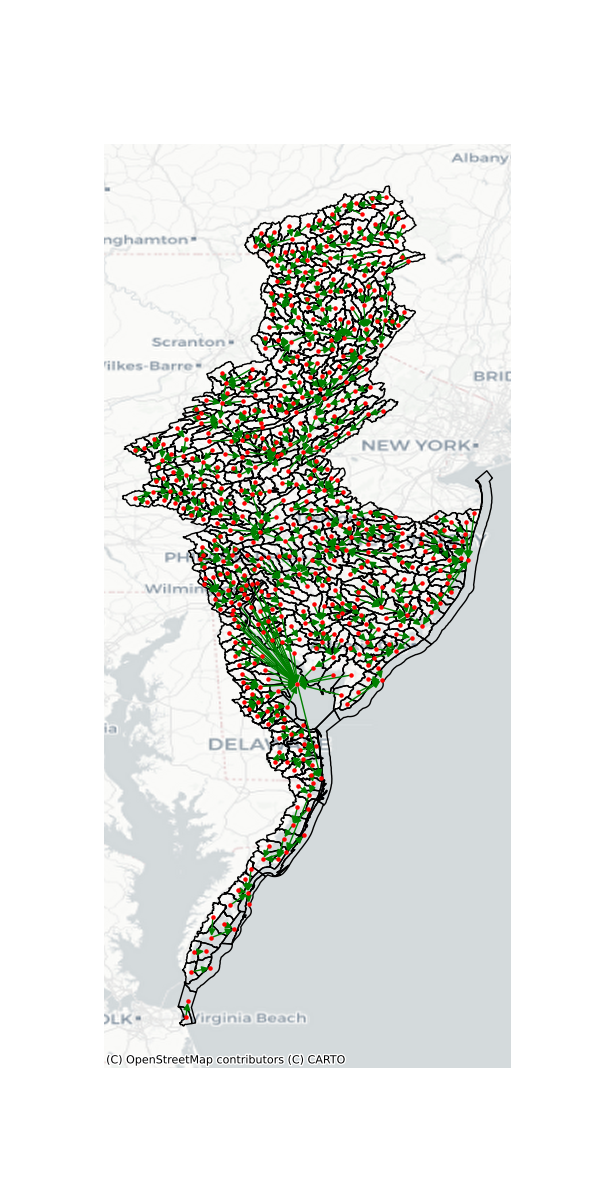

In [43]:
%matplotlib widget
ax = huc12s_in_and_outflows_gdf.plot(
    figsize=(6, 12),
    edgecolor='black',
    facecolor='none',
)

contextily.add_basemap(
    ax, 
    source=contextily.providers.CartoDB.Positron, 
    crs=huc12s_in_and_outflows_gdf.crs.to_string(), 
    zoom=7, 
    interpolation='sinc',
)

nx.draw(
    graph,
    positions,
    ax=ax,
    node_size=5,
    node_color="r",
    edge_color='g',
)

# Method 2: Find Multi Outlets from COMIDs
From Nord/Nordstop of COMIDs of reaches

In [44]:
# Read 'base_df_reach.parquet' created in Stage 1
reach_df = pd.read_parquet(
    project_path / 'stage1/data/' / 'base_df_reach.parquet'
)

reach_df.info()
reach_df.head(n=2)

<class 'pandas.core.frame.DataFrame'>
Index: 19496 entries, 1748535 to 932040370
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tp_conc             16823 non-null  float64 
 1   tn_conc             16823 non-null  float64 
 2   tss_conc            16823 non-null  float64 
 3   catchment_hectares  19496 non-null  float64 
 4   watershed_hectares  19496 non-null  float64 
 5   maflowv             19496 non-null  float64 
 6   geom                19494 non-null  object  
 7   cluster             17358 non-null  category
 8   sub_focusarea       186 non-null    Int64   
 9   nord                18870 non-null  Int64   
 10  nordstop            18844 non-null  Int64   
 11  huc12               19496 non-null  category
 12  streamorder         19496 non-null  int64   
 13  headwater           19496 non-null  int64   
 14  phase               4082 non-null   category
 15  fa_name             4082 non-nu

,tp_conc,tn_conc,tss_conc,catchment_hectares,watershed_hectares,maflowv,geom,cluster,sub_focusarea,nord,nordstop,huc12,streamorder,headwater,phase,fa_name
comid,,,,,,,,,,,,,,,,
1748535,0.0226,0.2643,9.9983,6496.7052,6501.69,43.699,b'\x01\x05\x00\x00\x80\x01\x00\x00\x00\x01\x02...,drb,<NA>,74914,74914,020401020302,1,1,NaN,NaN
1748537,0.0297,0.3166,8.8103,1663.1712,1664.46,11.189,b'\x01\x05\x00\x00\x80\x01\x00\x00\x00\x01\x02...,drb,<NA>,74913,74913,020401020302,1,1,NaN,NaN


## Explore functions

In [45]:
reach_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19496 entries, 1748535 to 932040370
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tp_conc             16823 non-null  float64 
 1   tn_conc             16823 non-null  float64 
 2   tss_conc            16823 non-null  float64 
 3   catchment_hectares  19496 non-null  float64 
 4   watershed_hectares  19496 non-null  float64 
 5   maflowv             19496 non-null  float64 
 6   geom                19494 non-null  object  
 7   cluster             17358 non-null  category
 8   sub_focusarea       186 non-null    Int64   
 9   nord                18870 non-null  Int64   
 10  nordstop            18844 non-null  Int64   
 11  huc12               19496 non-null  category
 12  streamorder         19496 non-null  int64   
 13  headwater           19496 non-null  int64   
 14  phase               4082 non-null   category
 15  fa_name             4082 non-nu

In [46]:
# need to drop reaches with no nord or nordstop values
df = reach_df[reach_df.nordstop.notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18844 entries, 1748535 to 932040370
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tp_conc             16795 non-null  float64 
 1   tn_conc             16795 non-null  float64 
 2   tss_conc            16795 non-null  float64 
 3   catchment_hectares  18844 non-null  float64 
 4   watershed_hectares  18844 non-null  float64 
 5   maflowv             18844 non-null  float64 
 6   geom                18844 non-null  object  
 7   cluster             17295 non-null  category
 8   sub_focusarea       186 non-null    Int64   
 9   nord                18844 non-null  Int64   
 10  nordstop            18844 non-null  Int64   
 11  huc12               18844 non-null  category
 12  streamorder         18844 non-null  int64   
 13  headwater           18844 non-null  int64   
 14  phase               4057 non-null   category
 15  fa_name             4057 non-nu

In [47]:
# Convenience function taken from `stage2/PA2_2b_AggregateAttenuated.ipynb`

def huc12_explore_comids(huc12: str) -> pd.DataFrame:
    columns = ['huc12','nord', 'nordstop','maflowv','tp_conc']
    df = reach_df[reach_df.nordstop.notna()].copy(deep=True)
    explore_outlets_df = df.loc[df.huc12==huc12, columns]
    explore_outlets_df['tp_load'] = (explore_outlets_df.tp_conc * 28.3168 / 1000000) * explore_outlets_df.maflowv * 31557600 
    explore_outlets_df['nord_diff'] = explore_outlets_df.nordstop - explore_outlets_df.nord
    return explore_outlets_df

In [48]:
# The outlet should have: lowest `nord`; the highest `maflowv`; largest difference between nord and nordstop
explore_huc12 = '020401010205' # Beers Brook-Middle West Branch Delaware River
print(explore_huc12, huc12s_in_and_outflows_gdf.loc[explore_huc12].huc12_name)
df = huc12_explore_comids(explore_huc12).sort_values(by=['nord'])
df.head(15)


020401010205 Beers Brook-Middle West Branch Delaware River


,huc12,nord,nordstop,maflowv,tp_conc,tp_load,nord_diff
comid,,,,,,,
2614074,020401010205,74197,74208,14.990,0.0098,131.273133,11
2613718,020401010205,74198,74208,14.989,0.0098,131.264375,10
2613710,020401010205,74199,74207,9.226,0.0078,64.306696,8
2613728,020401010205,74200,74206,5.715,0.0071,36.259576,6
2613722,020401010205,74201,74203,1.379,0.0077,9.488622,2
2614058,020401010205,74202,74203,0.911,0.0046,3.744763,1
2613698,020401010205,74203,74203,0.677,0.0042,2.540891,0
2613734,020401010205,74204,74206,2.767,0.0074,18.297385,2
2614070,020401010205,74205,74206,1.389,0.0049,6.082001,1


In [49]:
test_hucs = [
    '020401010101', # from_huc12s = None
    '020401010102', # 1  from_huc12s
    '020402050802', # 4  from_huc12s
]

explore_huc12 = '020401010102' 
print(explore_huc12, huc12s_in_and_outflows_gdf.loc[explore_huc12].huc12_name)
df = huc12_explore_comids(explore_huc12).sort_values(by=['nord'])
df.head(15)

020401010102 Betty Brook-Headwaters West Brach Delaware River


,huc12,nord,nordstop,maflowv,tp_conc,tp_load,nord_diff
comid,,,,,,,
2612800,020401010102,74290,74291,14.681,0.0361,473.599223,1
2612958,020401010102,74291,74291,1.855,0.0213,35.307881,0
2612922,020401010102,74292,74302,82.376,0.0434,3194.762439,10
2612790,020401010102,74301,74302,11.344,0.0500,506.855732,1
2612956,020401010102,74302,74302,0.502,0.0070,3.140146,0


In [50]:
# New function for finding outlets
df[df.nord == df.nord.min()]

,huc12,nord,nordstop,maflowv,tp_conc,tp_load,nord_diff
comid,,,,,,,
2612800,020401010102,74290,74291,14.681,0.0361,473.599223,1


In [51]:
nordmin = df.nord.min()
outlet = df[df.nord == nordmin].index.values.min()
nordmax = df.at[outlet, 'nordstop']

In [52]:
outlet = df[df.nord == nordmin].index.values
outlet

array([2612800])

In [53]:

trib1_df = df[(df.nord >= nordmin) & (df.nord <= nordmax)].sort_values(by=['nord'])
trib1_df

,huc12,nord,nordstop,maflowv,tp_conc,tp_load,nord_diff
comid,,,,,,,
2612800,020401010102,74290,74291,14.681,0.0361,473.599223,1
2612958,020401010102,74291,74291,1.855,0.0213,35.307881,0


## Create Function

In [54]:
def huc12_find_outlet_comids(huc12):
    outlet_comids = []
    df = huc12_explore_comids(huc12).sort_values(by=['nord'])
    while df.shape[0] > 0:
    # for trib in [1,2]:
        nordmin = df.nord.min()
        outlet = df[df.nord == nordmin].index.values.min()
        outlet_comids.append(outlet)
        nordmax = df.at[outlet, 'nordstop']
        trib_df = df[(df.nord >= nordmin) & (df.nord <= nordmax)]
        df.drop(trib_df.index, inplace=True)
    outlet_comids_tuple = tuple(outlet_comids) # hashable type require for df.apply()
    return outlet_comids_tuple

In [55]:
huc12 = '020402050802'
print(huc12, huc12s_in_and_outflows_gdf.loc[huc12].huc12_name)
huc12_find_outlet_comids(huc12)

020402050802 Drawyer Creek-Appoquinimink River


(24902810, 24902842, 4653798, 4653372)

In [56]:
huc12_explore_comids(huc12).sort_values(by=['nord'])

,huc12,nord,nordstop,maflowv,tp_conc,tp_load,nord_diff
comid,,,,,,,
24902810,020402050802,77094,77103,2.274,0.0179,36.374048,9
4653296,020402050802,77095,77103,0.508,0.0440,19.973976,8
4653298,020402050802,77096,77102,0.426,0.0566,21.546373,6
4653294,020402050802,77097,77099,0.244,0.0817,17.813942,2
4653302,020402050802,77098,77098,0.003,0.0172,0.046110,0
...,...,...,...,...,...,...,...
4653320,020402050802,77216,77216,0.008,NaN,NaN,0
4653316,020402050802,77217,77220,0.412,NaN,NaN,3
4653312,020402050802,77218,77220,0.361,NaN,NaN,2


In [57]:
# This case gives 4 outlet_comids, but two have NaN concs
huc12 = '020402050802'
print(huc12, huc12s_in_and_outflows_gdf.loc[huc12].huc12_name)
test = huc12_explore_comids(huc12).sort_values(by=['nord']).loc[list(huc12_find_outlet_comids(huc12))]
test

020402050802 Drawyer Creek-Appoquinimink River


,huc12,nord,nordstop,maflowv,tp_conc,tp_load,nord_diff
comid,,,,,,,
24902810,020402050802,77094,77103,2.274,0.0179,36.374048,9
24902842,020402050802,77105,77205,51.710,0.0181,836.375405,100
4653798,020402050802,77206,77220,0.753,NaN,NaN,14
4653372,020402050802,77224,77226,0.222,NaN,NaN,2


In [58]:
test.tp_load.sum()

872.749452614059

## Apply to HUC12s

In [59]:
huc12s_in_and_outflows_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   huc12_name    538 non-null    object  
 1   geometry      538 non-null    geometry
 2   centroid_xy   538 non-null    object  
 3   comid         523 non-null    Int64   
 4   nord          523 non-null    Int64   
 5   to_huc12      523 non-null    category
 6   outlet_comid  523 non-null    Int64   
 7   from_huc12s   249 non-null    object  
 8   inlet_comids  249 non-null    object  
dtypes: Int64(3), category(1), geometry(1), object(4)
memory usage: 78.0+ KB


In [60]:
test_hucs = [
    '020401010101', # from_huc12s = None
    '020401010102', # 1  from_huc12s
    '020402050802', # 4  from_huc12s
]

test_gdf = huc12s_in_and_outflows_gdf.iloc[1:4,:].copy(deep=True)
# Add huc12 as a column, in order to use the df.apply() function
test_gdf['outlet_comids'] = None
test_gdf


,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids
huc12,,,,,,,,,,
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","(-74.71393635968639, 42.38194565669812)",2612800,74290,020401010103,2612800,"(020401010101,)","(2612792,)",None
020401010103,Rose Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.77568 42.37921, -74.77530 42.379...","(-74.71097819143394, 42.330665690562654)",2612808,74288,020401010104,2612808,"(020401010102,)","(2612800,)",None
020401010104,Elk Creek-Headwaters West Brach Delaware River,"POLYGON ((-74.80026 42.40748, -74.79917 42.407...","(-74.82334627464569, 42.34506256688788)",2612820,74282,020401010106,2612820,"(020401010103,)","(2612808,)",None


In [61]:
test_gdf.index.to_series()

huc12
020401010102    020401010102
020401010103    020401010103
020401010104    020401010104
Name: huc12, dtype: category
Categories (538, object): ['020401010101' < '020401010102' < '020401010103' < '020401010104' ... '020403040403' < '020403040404' < '020403040501' < '020403040502']

In [62]:
# I can't figure out this error, so going with a loop.
# test_gdf['outlet_comids'] = test_gdf.index.to_series().apply(
#     lambda huc12: huc12_find_outlet_comids(huc12)
# )

for huc12 in test_gdf.index.to_series():
    test_gdf.at[huc12,'outlet_comids'] = huc12_find_outlet_comids(huc12)
test_gdf

,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids
huc12,,,,,,,,,,
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","(-74.71393635968639, 42.38194565669812)",2612800,74290,020401010103,2612800,"(020401010101,)","(2612792,)","(2612800, 2612922)"
020401010103,Rose Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.77568 42.37921, -74.77530 42.379...","(-74.71097819143394, 42.330665690562654)",2612808,74288,020401010104,2612808,"(020401010102,)","(2612800,)","(2612808,)"
020401010104,Elk Creek-Headwaters West Brach Delaware River,"POLYGON ((-74.80026 42.40748, -74.79917 42.407...","(-74.82334627464569, 42.34506256688788)",2612820,74282,020401010106,2612820,"(020401010103,)","(2612808,)","(2612820,)"


In [63]:
# Initialize column with None
huc12s_in_and_outflows_gdf['outlet_comids'] = None

for huc12 in huc12s_in_and_outflows_gdf.index.to_series():
    huc12s_in_and_outflows_gdf.at[huc12,'outlet_comids'] = huc12_find_outlet_comids(huc12)
huc12s_in_and_outflows_gdf.info()
huc12s_in_and_outflows_gdf.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
CategoricalIndex: 538 entries, 020401010101 to 020403040502
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   huc12_name     538 non-null    object  
 1   geometry       538 non-null    geometry
 2   centroid_xy    538 non-null    object  
 3   comid          523 non-null    Int64   
 4   nord           523 non-null    Int64   
 5   to_huc12       523 non-null    category
 6   outlet_comid   523 non-null    Int64   
 7   from_huc12s    249 non-null    object  
 8   inlet_comids   249 non-null    object  
 9   outlet_comids  538 non-null    object  
dtypes: Int64(3), category(1), geometry(1), object(5)
memory usage: 82.2+ KB


,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids
huc12,,,,,,,,,,
020401010101,Town Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.59363 42.42361, -74.59395 42.423...","(-74.62155936289159, 42.387091234041016)",2612792,74293,020401010102,2612792,None,None,"(2612792,)"
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","(-74.71393635968639, 42.38194565669812)",2612800,74290,020401010103,2612800,"(020401010101,)","(2612792,)","(2612800, 2612922)"
020401010103,Rose Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.77568 42.37921, -74.77530 42.379...","(-74.71097819143394, 42.330665690562654)",2612808,74288,020401010104,2612808,"(020401010102,)","(2612800,)","(2612808,)"
020401010104,Elk Creek-Headwaters West Brach Delaware River,"POLYGON ((-74.80026 42.40748, -74.79917 42.407...","(-74.82334627464569, 42.34506256688788)",2612820,74282,020401010106,2612820,"(020401010103,)","(2612808,)","(2612820,)"
020401010105,Upper Little Delaware River,"POLYGON ((-74.73673 42.31516, -74.73631 42.315...","(-74.78436638151948, 42.27096486797448)",2612842,74311,020401010106,2612842,None,None,"(2612842,)"


## Replace None with empty tuples

In [64]:
columns = ['from_huc12s', 'inlet_comids', 'outlet_comids']
huc12s_in_and_outflows_gdf.loc[:,columns].isnull()

,from_huc12s,inlet_comids,outlet_comids
huc12,,,
020401010101,True,True,False
020401010102,False,False,False
020401010103,False,False,False
020401010104,False,False,False
020401010105,True,True,False
...,...,...,...
020403040402,True,True,False
020403040403,True,True,False
020403040404,True,True,False


In [ ]:
# skipping this effort for now

## Confirm results

In [65]:
huc12s_in_and_outflows_gdf.loc[test_hucs,:]

,huc12_name,geometry,centroid_xy,comid,nord,to_huc12,outlet_comid,from_huc12s,inlet_comids,outlet_comids
huc12,,,,,,,,,,
020401010101,Town Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.59363 42.42361, -74.59395 42.423...","(-74.62155936289159, 42.387091234041016)",2612792,74293,020401010102,2612792,None,None,"(2612792,)"
020401010102,Betty Brook-Headwaters West Brach Delaware River,"POLYGON ((-74.69614 42.42722, -74.69579 42.427...","(-74.71393635968639, 42.38194565669812)",2612800,74290,020401010103,2612800,"(020401010101,)","(2612792,)","(2612800, 2612922)"
020402050802,Drawyer Creek-Appoquinimink River,"POLYGON ((-75.67083 39.50635, -75.67054 39.505...","(-75.67735945318249, 39.446990694329)",24902810,77094,020402040000,24902810,None,None,"(24902810, 24902842, 4653798, 4653372)"


In [73]:
# Value counts for HUC12s with multiple outlet COMIDs
# Length of outlets list
huc12s_in_and_outflows_gdf.outlet_comids.apply(len).value_counts()

outlet_comids
1     364
2      81
0      58
3      17
4       6
5       3
7       2
9       2
6       2
24      1
17      1
13      1
Name: count, dtype: int64

# Save output to parquet

In [66]:
huc12s_in_and_outflows_gdf.to_parquet(
    geography_path / 'huc12s_in_and_outflows_gdf.parquet',
    engine='pyarrow',
)

# COMID Level, work in progress

INCOMPLETE

In [ ]:
reach_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 19496 entries, 1748535 to 932040370
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   watershed_hectares  19496 non-null  float64 
 1   maflowv             19496 non-null  float64 
 2   geometry            19494 non-null  geometry
 3   cluster             17358 non-null  category
 4   sub_focusarea       186 non-null    Int64   
 5   nord                18870 non-null  Int64   
 6   nordstop            18844 non-null  Int64   
 7   huc12               19496 non-null  category
 8   streamorder         19496 non-null  int64   
 9   headwater           19496 non-null  int64   
 10  phase               4082 non-null   category
 11  fa_name             4082 non-null   category
 12  in_drb              19496 non-null  boolean 
 13  huc08               19496 non-null  category
 14  huc10               19496 non-null  category
 15  into_dr             194

In [ ]:
reach_gdf = reach_gdf.to_crs(huc12_gdf.crs)
reach_gdf['huc12_outlet'] = reach_gdf.index.to_series().apply(
    lambda comid: comid in huc12_gdf.outlet_comid.values
)

In [ ]:
huc12_gdf.hvplot(
    geo=True,
    tiles='StamenTerrain',
    #crs=reach_gdf.loc[reach_gdf['huc12_outlet']].crs.to_epsg(),
) * reach_gdf.loc[reach_gdf['huc12_outlet']].hvplot(
    #geo=True,
    frame_width=500,
    line_color='red',
)

IndexError: list index out of range

In [ ]:
catch_gdf = gpd.read_parquet(
    geography_path / 'catch_gdf.parquet'
)
print(catch_gdf.shape)
catch_gdf.head(n=2)

(19496, 15)


,catchment_hectares,watershed_hectares,geometry,cluster,sub_focusarea,nord,nordstop,huc12,streamorder,headwater,phase,fa_name,in_drb,huc08,huc10
comid,,,,,,,,,,,,,,,
1748535,6496.7052,6501.69,"MULTIPOLYGON (((-8301340.781 5199034.787, -830...",drb,<NA>,74914,74914,020401020302,1,1,NaN,NaN,True,02040102,0204010203
1748537,1663.1712,1664.46,"MULTIPOLYGON (((-8304909.314 5200051.727, -830...",drb,<NA>,74913,74913,020401020302,1,1,NaN,NaN,True,02040102,0204010203
